In [1]:
#ActivePlane.py (POINT: )
#! /usr/bin/env python

'''
WARNING: THIS TOOL IS STILL UNDER DEVELOPMENT. KNOWN BUGS ARE PRESENT.
'''

'''
Inputs:
(define the plane with 3 points)
a_point = [0, 0, 0]
b_point = [1, 0, 1]
c_point = [0, 1, 0]
'''

import math
import numpy as np
import matplotlib.pyplot as plt
import macrodensity as md
#------------------------------------------------------------------
# Get the potential
#------------------------------------------------------------------
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density('CHGCAR.test')
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
cutoff_varience = 1.0
## Get the gradiens (Field), if required.
## Comment out if not required, due to compuational expense.
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
## Convert the fractional points to grid points on the density surface
a = md.numbers_2_grid([0, 0, 0],NGX,NGY,NGZ)
b = md.numbers_2_grid([1, 0, 1],NGX,NGY,NGZ)
c = md.numbers_2_grid([0, 1, 0],NGX,NGY,NGZ)
plane_coeff = md.points_2_plane(a,b,c)

## Get the gradients
XY = np.multiply(grad_x,grad_y)
grad_mag = np.multiply(XY,grad_z)

## Create the plane
xx,yy,grd =  md.create_plotting_mesh(NGX,NGY,NGZ,plane_coeff,grad_x)
## Plot the surface
plt.contourf(xx,yy,grd,V)
plt.show()

##------------------------------------------------------------------
## Plotting a planar average (Field/potential) throughout the material
##------------------------------------------------------------------
## FIELDS
planar = md.planar_average(grad_x,NGX,NGY,NGZ)
## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,4.80,resolution_z)
plt.plot(planar)
plt.plot(macro)
plt.savefig('Planar.eps')
plt.show()

Reading header information...


FileNotFoundError: [Errno 2] No such file or directory: 'CHGCAR.test'

In [3]:
#ActivePlane.py
#! /usr/bin/env python

'''
Distinguish plateau regions in the electrostatic potential

Inputs:
cube_size = size of the cube in units of FFT mesh points (NGX/Y/Z)
cube_origin = real-space positioning of the bottom left point of the sampling cube (fractional coordinates of the unit cell).
tolerance = threshold below which the electrostatic potential is considered to be plateaued
input_file = VASP LOCPOT input filename to be read

Outputs:
Percentage of vaccum vs non-vacuum cubes
'''

import math
import numpy as np
from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, numbers_2_grid, volume_average

## INPUT SECTION
cube_size = [2,2,2]
cube_origin = [0.5,0.5,0.5]
tolerance = 1E-4
input_file = 'LOCPOT.test' #(POINT: added .test to file name for code to work)
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)
cutoff_varience = tolerance
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
travelled = [0,0,0]

## DISTNGUISHING VACCUM FROM NON_VACUUM
vacuum = []
non_vacuum = []
for i in range(0,NGX,cube_size[0]):
    for j in range(0,NGY,cube_size[1]):
        for k in range(0,NGZ,cube_size[2]):
            sub_origin = [float(i)/NGX,float(j)/NGY,float(k)/NGZ]
            cube_pot, cube_var = volume_average(origin=sub_origin,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ,travelled=[0,0,0])
            if cube_var <= cutoff_varience:
                vacuum.append(sub_origin)
            else:
                non_vacuum.append(sub_origin)

## PRINTING
print("Number of vacuum cubes: ", len(vacuum))
print("Number of non-vacuum cubes: ", len(non_vacuum))
print("Percentage of vacuum cubes: ",(float(len(vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))
print("Percentage of non-vacuum cubes: ",(float(len(non_vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Number of vacuum cubes:  17
Number of non-vacuum cubes:  4079
Percentage of vacuum cubes:  0.4150390625
Percentage of non-vacuum cubes:  99.5849609375


In [4]:
#BulkInterstitialAlignment 
#! /usr/bin/env python

'''
Alignment of the band edges with the interstitial bulk reference potential.

Inputs:
intersices = Positions of the pores/interstices ([[interstice1],[interstice2],...])
outcar = VASP OUTCAR input filename
locpot = VASP LOCPOT input filename
cube_size = a cube defined by LOCPOT FFT mesh points

Output:
Aligned Valence Band, Aligned Conduction Band, Interstitial variances
'''

from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, volume_average
from macrodensity.vasp import get_band_extrema

## INPUT SECTION
interstices = ([0.5,0.5,0.5],[0.25,0.25,0.25]) #(POINT: typo error here)
outcar = 'OUTCAR.test'
locpot = 'LOCPOT.test'
cube_size = [2,2,2]
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(locpot,quiet=True)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)

## GETTING BAND EDGES
band_extrema = get_band_extrema(outcar)
VB_eigenvalue = band_extrema[0]
CB_eigenvalue = band_extrema[1]

## CALCULATING REFERENCE STATE
interstitial_potentials = []
interstitial_variances = []
for interstice in interstices:
    locpot_extract = volume_average(origin=interstice,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ)
    interstitial_potentials.append(locpot_extract[0])
    interstitial_variances.append(locpot_extract[1])

## CALCULATING ALIGNED BAND ENERGIES
sum_interstitial_potential = 0
for ele in interstitial_potentials:
    sum_interstitial_potential += ele
average_interstitial_potential = sum_interstitial_potential/len(interstitial_potentials)
VB_aligned = round(VB_eigenvalue - average_interstitial_potential,2)
CB_aligned = round(CB_eigenvalue - average_interstitial_potential,2)

## PRINTING
print("Reading band edges from file: "+str(outcar))
print("Reading potential from file: "+str(locpot))
print("Interstital variances: "+str(interstitial_variances))
print("VB_aligned (eV)      CB_aligned (eV)") #(POINT: added units)
print("--------------------------------")
print(VB_aligned,"         ",CB_aligned)


Reading header information...
Reading 3D data using Pandas...
Reading band edges from file: OUTCAR.test
Reading potential from file: LOCPOT.test
Interstital variances: [1.8665165271901357e-05, 6.277207757909537e-06]
VB_aligned (eV)      CB_aligned (eV)
--------------------------------
-3.24           -1.72


In [5]:
#FieldAtPoint
#! /usr/bin/env python

'''
Alignment of the band edges with the interstitial bulk reference potential.

Inputs:
intersices = Positions of the pores/interstices ([[interstice1],[interstice2],...])
outcar = VASP OUTCAR input filename
locpot = VASP LOCPOT input filename
cube_size = a cube defined by LOCPOT FFT mesh points

Output:
Aligned Valence Band, Aligned Conduction Band, Interstitial variances
'''

from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, volume_average
from macrodensity.vasp import get_band_extrema

## INPUT SECTION
intersices = ([0.5,0.5,0.5],[0.25,0.25,0.25])
outcar = 'OUTCAR.test'
locpot = 'LOCPOT.test'
cube_size = [2,2,2]
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(locpot,quiet=True)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)

## GETTING BAND EDGES
band_extrema = get_band_extrema(outcar)
VB_eigenvalue = band_extrema[0]
CB_eigenvalue = band_extrema[1]

## CALCULATING REFERENCE STATE
interstitial_potentials = []
interstitial_variances = []
for interstice in interstices:
    locpot_extract = volume_average(origin=interstice,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ)
    interstitial_potentials.append(locpot_extract[0])
    interstitial_variances.append(locpot_extract[1])

## CALCULATING ALIGNED BAND ENERGIES
sum_interstitial_potential = 0
for ele in interstitial_potentials:
    sum_interstitial_potential += ele
average_interstitial_potential = sum_interstitial_potential/len(interstitial_potentials)
VB_aligned = round(VB_eigenvalue - average_interstitial_potential,2)
CB_aligned = round(CB_eigenvalue - average_interstitial_potential,2)

## PRINTING
print("Reading band edges from file: "+str(outcar))
print("Reading potential from file: "+str(locpot))
print("Interstital variances: "+str(interstitial_variances))
print("VB_aligned      CB_aligned")
print("--------------------------------")
print(VB_aligned,"         ",CB_aligned)


Reading header information...
Reading 3D data using Pandas...
Reading band edges from file: OUTCAR.test
Reading potential from file: LOCPOT.test
Interstital variances: [1.8665165271901357e-05, 6.277207757909537e-06]
VB_aligned      CB_aligned
--------------------------------
-3.24           -1.72


In [6]:
#GulpPotential.py
#! /usr/bin/env python

'''
Alignment of the band edges with the interstitial bulk reference potential.

Inputs:
intersices = Positions of the pores/interstices ([[interstice1],[interstice2],...])
outcar = VASP OUTCAR input filename
locpot = VASP LOCPOT input filename
cube_size = a cube defined by LOCPOT FFT mesh points

Output:
Aligned Valence Band, Aligned Conduction Band, Interstitial variances
'''

from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, volume_average
from macrodensity.vasp import get_band_extrema

## INPUT SECTION
intersices = ([0.5,0.5,0.5],[0.25,0.25,0.25])
outcar = 'OUTCAR.test'
locpot = 'LOCPOT.test'
cube_size = [2,2,2]
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(locpot,quiet=True)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)

## GETTING BAND EDGES
band_extrema = get_band_extrema(outcar)
VB_eigenvalue = band_extrema[0]
CB_eigenvalue = band_extrema[1]

## CALCULATING REFERENCE STATE
interstitial_potentials = []
interstitial_variances = []
for interstice in interstices:
    locpot_extract = volume_average(origin=interstice,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ)
    interstitial_potentials.append(locpot_extract[0])
    interstitial_variances.append(locpot_extract[1])

## CALCULATING ALIGNED BAND ENERGIES
sum_interstitial_potential = 0
for ele in interstitial_potentials:
    sum_interstitial_potential += ele
average_interstitial_potential = sum_interstitial_potential/len(interstitial_potentials)
VB_aligned = round(VB_eigenvalue - average_interstitial_potential,2)
CB_aligned = round(CB_eigenvalue - average_interstitial_potential,2)

## PRINTING
print("Reading band edges from file: "+str(outcar))
print("Reading potential from file: "+str(locpot))
print("Interstital variances: "+str(interstitial_variances))
print("VB_aligned      CB_aligned")
print("--------------------------------")
print(VB_aligned,"         ",CB_aligned)


Reading header information...
Reading 3D data using Pandas...
Reading band edges from file: OUTCAR.test
Reading potential from file: LOCPOT.test
Interstital variances: [1.8665165271901357e-05, 6.277207757909537e-06]
VB_aligned      CB_aligned
--------------------------------
-3.24           -1.72


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


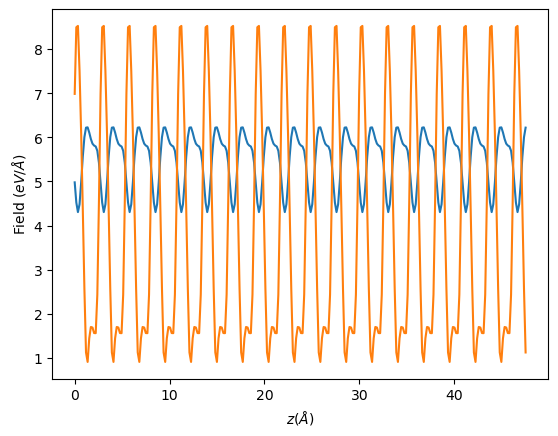

In [13]:
#InputControl
#! /usr/bin/env python
import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
#from itertools import izip #(POINT: Hashed because of Python3 compatibility issues)

#'''
#WARNING: THIS TOOL IS STILL UNDER DEVELOPMENT. KNOWN BUGS ARE PRESENT.
#'''


#------------------------------------------------------------------
# Get the potential
# This section should not be altered
#------------------------------------------------------------------
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density('LOCPOT.test')
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
## Get the gradiens (Field), if required.
## Comment out if not required, due to compuational expense.
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
#------------------------------------------------------------------

##------------------------------------------------------------------
## Plotting the average in a moving cube along a vector
##------------------------------------------------------------------
## cube defines the size of the cube in units of mesh points (NGX/Y/Z)
cube = [2,2,2]
## vector is the vector you wish to travel along
vector = [1,1,0]
## cube defines the origin of the line in units of mesh points (NGX/Y/Z)
origin = [0.5,0,0.5]
## magnitude defines the length of the line, in units of mesh points (NGX/Y/Z)
magnitude = 280
## IF YOU WANT TO PLOT THE POTENTIAL:
cubes_potential = md.travelling_volume_average(grid_pot,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = md.vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)
plt.plot(abscissa, cubes_potential)
plt.xlabel("$z (\AA)$")
plt.ylabel("Potential (eV)")
## IF YOU WANT TO PLOT THE FIELD MAGNITUDE ALSO:
## Get the gradients (of the field, if required)
grad_mag = md.gradient_magnitude(grad_x,grad_y,grad_z)
cubes_field = md.travelling_volume_average(grad_mag,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = md.vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)
plt.plot(abscissa, cubes_field)
plt.xlabel("$z (\AA)$")
plt.ylabel("Field $(eV/\AA)$")
with open('ElectricField.csv','w')as f:
    writer = csv.writer(f)
    writer.writerow(['abscissa', 'cubes_field']) #(POINT : PYTHON3 INCOMPATIBLE)
    for row in zip(abscissa, cubes_field):
        writer.writerow(row)

temp = pd.read_csv('ElectricField.csv', sep=',')    
np.asarray(temp.values).tofile('ElectricField.dat')


In [14]:
import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt


'''
WARNING: THIS TOOL IS STILL UNDER DEVELOPMENT. KNOWN BUGS ARE PRESENT.
'''


#------------------------------------------------------------------
#   READING
# Get the two potentials and change them to a planar average.
# This section should not be altered
#------------------------------------------------------------------
# SLAB
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density('CHGCAR.test')
mag_a,mag_b,mag_c,vec_a,vec_b,vec_c = md.matrix_2_abc(Lattice)
resolution_x = mag_a/NGX
resolution_y = mag_b/NGY
resolution_z = mag_c/NGZ
Volume = md.get_volume(vec_a,vec_b,vec_c)
grid_pot_slab, electrons_slab = md.density_2_grid(vasp_pot,NGX,NGY,NGZ,True,Volume)
# Save the lattce vectors for use later
Vector_A = [vec_a,vec_b,vec_c]
#----------------------------------------------------------------------------------
# CONVERT TO PLANAR DENSITIES
#----------------------------------------------------------------------------------
planar_slab = md.planar_average(grid_pot_slab,NGX,NGY,NGZ)
# BULK
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density('CHGCAR.test')
mag_a,mag_b,mag_c,vec_a,vec_b,vec_c = md.matrix_2_abc(Lattice)
resolution_x = mag_a/NGX
resolution_y = mag_b/NGY
resolution_z = mag_c/NGZ
# Save the lattce vectors for use later
Vector_B = [vec_a,vec_b,vec_c]
Volume = md.get_volume(vec_a,vec_b,vec_c)
#----------------------------------------------------------------------------------
# CONVERT TO PLANAR DENSITIES
#----------------------------------------------------------------------------------
grid_pot_bulk, electrons_bulk = md.density_2_grid(vasp_pot,NGX,NGY,NGZ,True,Volume)
planar_bulk = md.planar_average(grid_pot_bulk,NGX,NGY,NGZ)
#----------------------------------------------------------------------------------
# FINISHED READING
#----------------------------------------------------------------------------------
# GET RATIO OF NUMBERS OF ELECTRONS
#----------------------------------------------------------------------------------
elect_ratio = int(electrons_slab/electrons_bulk)
#----------------------------------------------------------------------------------
# SPLINE THE TWO GENERATING A DISTANCE ON ABSCISSA
#----------------------------------------------------------------------------------
slab, bulk = md.beta_tools.matched_spline_generate(planar_slab,planar_bulk,Vector_A[2],Vector_B[1])
#----------------------------------------------------------------------------------
# EXTEND THE BULK POTENTIAL TO MATCH THE ELECTRON NUMBERS
#----------------------------------------------------------------------------------
bulk = md.beta_tools.extend_potential(bulk,elect_ratio,Vector_B[1])
#----------------------------------------------------------------------------------
# MATCH THE RESOLUTIONS OF THE TWO
#----------------------------------------------------------------------------------
slab, bulk = md.beta_tools.match_resolution(slab, bulk)
plt.plot(bulk[:,1])
plt.show()
#----------------------------------------------------------------------------------
# TRANSLATE THE BULK POTENTIAL TO GET OVERLAP
#----------------------------------------------------------------------------------
bulk_trans = md.beta_tools.translate_grid(bulk, 3.13,True,np.dot(Vector_B[1],elect_ratio),0.42)
bulk_trans = md.beta_tools.translate_grid(bulk_trans, 6.57,False,np.dot(Vector_B[1],elect_ratio),0.42)
slab_trans = md.beta_tools.translate_grid(slab, 6.5653,True,Vector_A[2])
#potential_difference = md.diff_potentials(pot_slab_orig,bulk_extd,10,40,tol=0.04)

##------------------------------------------------------------------
## SET THE CHARGE DENSITY TO ZERO OUTSIDE THE BULK
bulk_vacuum = md.beta_tools.bulk_vac(bulk_trans, slab_trans)
plt.plot(bulk_vacuum[:,0],bulk_vacuum[:,1])
plt.plot(slab_trans[:,0],slab_trans[:,1],)
plt.show()
# GET THE DIFFERENCES (within a numerical tolerence)
difference = md.beta_tools.subs_potentials(slab_trans,bulk_vacuum,tol=0.01)
difference = md.beta_tools.spline_generate(difference, 3) #(POINT: Float-Integer error)
plt.plot(difference[:,0],difference[:,1])

#plt.plot(difference[:,0],difference[:,1])
plt.show()


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  8.000000069794417
Total electrons:  8.000000069794574
Reading header information...
Reading 3D data using Pandas...
Average of the potential =  8.000000069794417
Total electrons:  8.000000069794574


AttributeError: module 'macrodensity' has no attribute 'beta_tools'

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


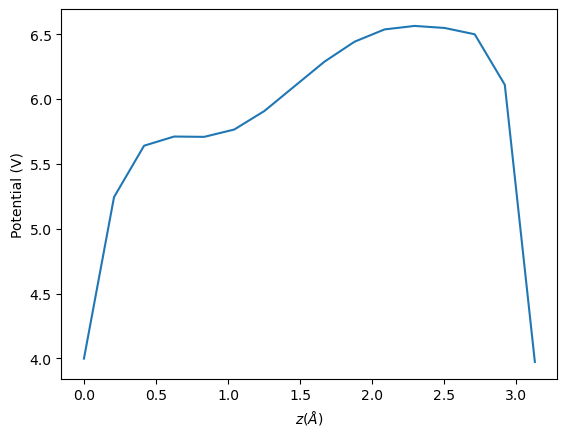

In [15]:
#MovingCube 
#! /usr/bin/env python

'''
Electrostatic potential plot spanning a vector acros the unit cell

Inputs:
cube = size of the cube in units of FFT mesh points (NGX/Y/Z)
origin = real-space positioning of the bottom left point of the sampling cube (fractional coordinates of the unit cell).
vector = vector across which the unit cell is traversed (hkl convention)
magnitude = length travelled along the selected vector in units of FFT mesh points (NGX/Y/Z)
input_file = VASP LOCPOT input filename to be read
output file = name of output data file
img_file = name of output image file

Outputs:
averaged electrostatic potential for the set cube size (list)
.csv file containing the above data
.png file presenting the above data
'''
from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, vector_2_abscissa, travelling_volume_average
import matplotlib.pyplot as plt
import pandas as pd

## INPUT SECTION
cube = [1,1,1]
origin = [0.17,0.17,0.17]
vector = [1,1,1]
magnitude = 16
input_file = 'LOCPOT.test'
output_file ='MovingCube.csv'
img_file ='MovingCube.png'
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)
cubes_potential = travelling_volume_average(grid_pot,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)

## PLOTTING
plt.plot(abscissa, cubes_potential)
plt.xlabel("$z (\AA)$")
plt.ylabel("Potential (V)") #(POINT: Fixed the axis title)
plt.savefig(img_file)

##SAVING
df = pd.DataFrame.from_dict({'Potential':cubes_potential},orient='index')
df = df.transpose()
df.to_csv(output_file)


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


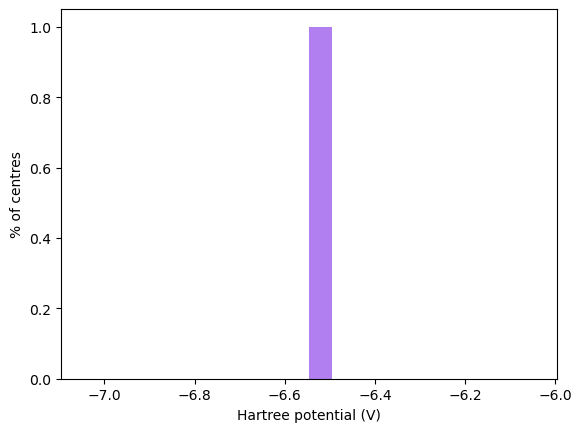

In [16]:
#OnsitePotential 
#! /usr/bin/env python

'''
Electrostatic potential at atomic sites

Inputs:
potential_file = VASP LOCPOT
coordinate_file = The coordinates file NOTE This must be in vasp 4 format
species = The species whose on-site potential you are interested in (string)
sample_cube = The size of the sampling cube in units of mesh points (NGX/Y/Z)
output file = name of output data file
img_file = name of output image file

Outputs:
.png histogram output
.csv data output
'''
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import ase
import pandas as pd
from ase.io import write
from ase.io import vasp
from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, numbers_2_grid, planar_average, macroscopic_average,volume_average

## INPUT SECTION
potential_file = 'LOCPOT.test'
coordinate_file = 'POSCAR.test'
species = "Zn"
sample_cube = [5,5,5]
output_file = 'OnSitePotential.csv'
img_file = 'OnSitePotential.png'
## END INPUT SECTION

## GETTING POTENTIALS
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(potential_file)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
coords = ase.io.vasp.read_vasp(coordinate_file)
scaled_coords = coords.get_scaled_positions()
symbols = coords.get_chemical_symbols()
ox_coords = []

for i, atom in enumerate(coords):
    if symbols[i] == species:
        ox_coords.append(scaled_coords[i])
grid_position = np.zeros(shape=(3))
potentials_list = []
i = 0
num_bins = 20
for coord in ox_coords:
    i = i + 1
    grid_position[0] = coord[0]
    grid_position[1] = coord[1]
    grid_position[2] = coord[2]
    cube = sample_cube
    origin = [grid_position[0]-2,grid_position[1]-2,grid_position[2]-1]
    travelled = [0,0,0]
    cube_potential, cube_var = volume_average(origin,cube,grid_pot,NGX,NGY,NGZ)
    potentials_list.append(cube_potential)

## PLOTTING
n, bins, patches = plt.hist(potentials_list, num_bins, facecolor='#6400E1', alpha=0.5)
plt.xlabel('Hartree potential (V)')
plt.ylabel('% of centres')
plt.savefig(img_file)

## SAVING
df = pd.DataFrame.from_dict({'Potential':potentials_list},orient='index')
df = df.transpose()
df.to_csv(output_file)


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Average of the average =  -0.07045532018119124


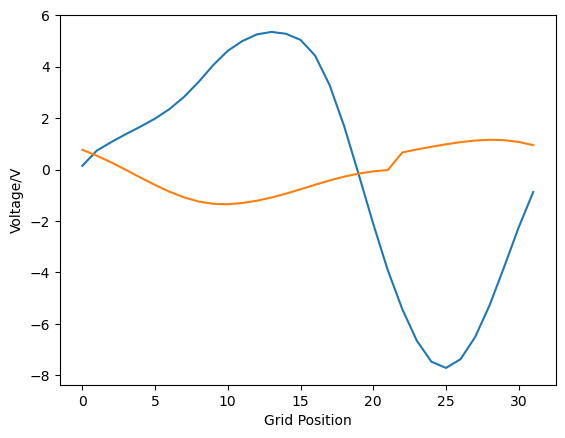

In [17]:
#PlanarAverage
#! /usr/bin/env python

'''
Planar and macroscopic average calculation

Inputs:
input_file = input filename to be read (must be in .cube format)
lattice_vector = Repeating unit over which the potential is averaged to get the macroscopic average (Angstroms)
output file = name of output data file
img_file = name of output image file

Outputs:
planar average, macroscopic average, interpolated planar average
.csv data file containing: planar average, macroscopic average, interpolated planar average
image file plotting .csv data
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, planar_average, macroscopic_average

## INPUT SECTION
input_file = 'LOCPOT.test'
lattice_vector = 5.41
output_file = 'PlanarAverage.csv'
img_file = 'PlanarAverage.png'
## END INPUT SECTION

# GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)

## PLANAR AVERAGE
planar = planar_average(grid_pot,NGX,NGY,NGZ)

## MACROSCOPIC AVERAGE
macro = macroscopic_average(planar,lattice_vector,resolution_z)

## PLOTTING
plt.ylabel('Voltage/V')
plt.xlabel('Grid Position')
plt.plot(planar)
plt.plot(macro)
plt.savefig(img_file)

## SAVING
df = pd.DataFrame.from_dict({'Planar':planar,'Macroscopic':macro},orient='index')
df = df.transpose()
df.to_csv(output_file)


Average of the average =  0.004323820372140808


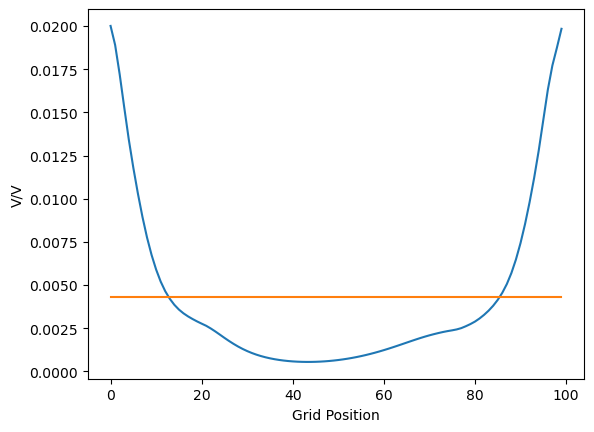

In [18]:
#PlanarCube 
#! /usr/bin/env python

'''
Planar and macroscopic average for cube files

Inputs:
input_file = input filename to be read (must be in .cube format)
lattice_vector = Repeating unit over which the potential is averaged to get the macroscopic average (Angstroms)
output file = name of output data file
img_file = name of output image file

Outputs:
planar average, macroscopic average, interpolated planar average
.csv data file containing: planar average, macroscopic average, interpolated planar average
image file plotting .csv data
'''
import math
import numpy as np
import matplotlib.pyplot as plt
import ase.io.cube
import pandas as pd
from macrodensity.density import planar_average, macroscopic_average

## INPUT SECTION
input_file = "cube_001_spin_density.cube"
lattice_vector = 4.75
output_file = 'PlanarCube.csv'
img_file = 'PlanarCube.png'
## END INPUT SECTION

# GETTING POTENTIAL
potential, atoms = ase.io.cube.read_cube_data(input_file)
vector_a = np.linalg.norm(atoms.cell[1])
vector_b = np.linalg.norm(atoms.cell[1])
vector_c = np.linalg.norm(atoms.cell[2])
NGX = len(potential)
NGY = len(potential[0])
NGZ = len(potential[0][0])
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ

## PLANAR AVERAGE
planar = planar_average(potential,NGX,NGY,NGZ)

## MACROSCOPIC AVERAGE
macro  = macroscopic_average(planar,lattice_vector,resolution_z)

## PLOTTING
plt.ylabel('V/V')
plt.xlabel('Grid Position')
plt.plot(planar)
plt.plot(macro)
plt.savefig(img_file)

## SAVING
df = pd.DataFrame.from_dict({'Planar':planar,'Macroscopic':macro},orient='index')
df = df.transpose()
df.to_csv(output_file)


In [19]:
#PlaneField
#! /usr/bin/env python

'''
WARNING: THIS TOOL IS STILL UNDER DEVELOPMENT. KNOWN BUGS ARE PRESENT.
'''

import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt


## Input section (define the plane with 3 points, fractional coordinates)
a_point = [0, 0, 0]
b_point = [1, 0, 1]
c_point = [0, 1, 0]

input_file = 'LOCPOT.test'

# No need to alter anything after here
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
## Get the gradiens (Field), if required.
## Comment out if not required, due to compuational expense.
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
#------------------------------------------------------------------


##------------------------------------------------------------------
## Get the equation for the plane
## This is the section for plotting on a user defined plane;
## uncomment commands if this is the option that you want.
##------------------------------------------------------------------

## Convert the fractional points to grid points on the density surface
a = md.numbers_2_grid(a_point,NGX,NGY,NGZ)
b = md.numbers_2_grid(b_point,NGX,NGY,NGZ)
c = md.numbers_2_grid(c_point,NGX,NGY,NGZ)
plane_coeff = md.beta_tools.points_2_plane(a,b,c)

## Get the gradients
XY = np.multiply(grad_x,grad_y)
grad_mag = np.multiply(XY,grad_z)

## Create the plane
xx,yy,grd =  md.beta_tools.create_plotting_mesh(NGX,NGY,NGZ,plane_coeff,grad_x)
## Plot the surface
plt.contour(xx,yy,grd,1)
plt.show()
##------------------------------------------------------------------
##------------------------------------------------------------------


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


AttributeError: module 'macrodensity' has no attribute 'beta_tools'

In [23]:
#Plot_Slab_Bulk 
import macrodensity as pot #(POINT: previous package quoted was PotentialModule (replaced with macrodensity.density_tools))
import math
import numpy as np
import matplotlib.pyplot as plt
import sys


### THE INPUT PARAMETERS

input_file_1='CHGCAR.test'
input_file_2='CHGCAR.test'
absc_1 = 2
absc_2 = 2
### END INPUT PARAMETERS
#------------------------------------------------------------------
#   READING
# Get the two potentials and change them to a planar average.
# This section should not be altered
#------------------------------------------------------------------
## SLAB
vasp_pot, NGX, NGY, NGZ, Lattice = pot.read_vasp_density(input_file_1)
mag_a,mag_b,mag_c,vec_a,vec_b,vec_c = pot.matrix_2_abc(Lattice)
resolution_x = mag_a/NGX
resolution_y = mag_b/NGY
resolution_z = mag_c/NGZ
Volume = pot.get_volume(vec_a,vec_b,vec_c)
grid_pot_slab, electrons_slab = pot.density_2_grid(vasp_pot,NGX,NGY,NGZ,True,Volume)
# Save the lattce vectors for use later
Vector_A = [vec_a,vec_b,vec_c]
##----------------------------------------------------------------------------------
## CONVERT TO PLANAR DENSITIES
##----------------------------------------------------------------------------------
slab = pot.planar_average_charge(grid_pot_slab,NGX,NGY,NGZ,Vector_A) #(POINT: no such function called planar_average_charge, only planar_average_charge)
slab = pot.add_abscissa(slab,np.linalg.norm(Vector_A[absc_1]))
np.savetxt('Slab.dat',slab)
# Save the length of this for later to re-adjust dz in the Areal density
#----------------------------------------------------------------------------------
## BULK
vasp_pot, NGX, NGY, NGZ, Lattice = pot.read_vasp_density(input_file_2)
mag_a,mag_b,mag_c,vec_a,vec_b,vec_c = pot.matrix_2_abc(Lattice)
resolution_x = mag_a/NGX
resolution_y = mag_b/NGY
resolution_z = mag_c/NGZ
Volume = pot.get_volume(vec_a,vec_b,vec_c)
grid_pot_bulk, electrons_bulk = pot.density_2_grid(vasp_pot,NGX,NGY,NGZ,True,Volume)
# Save the lattce vectors for use later
Vector_B = [vec_a,vec_b,vec_c]
##----------------------------------------------------------------------------------
## CONVERT TO PLANAR DENSITIES
##----------------------------------------------------------------------------------
bulk = pot.planar_average_charge(grid_pot_bulk,NGX,NGY,NGZ,Vector_B)
# Save the length of this for later to re-adjust dz in the Areal density
#----------------------------------------------------------------------------------
# FINISHED READING
#----------------------------------------------------------------------------------
# Create 2D arrays with the length from the 1D arrays of charge
bulk = pot.add_abscissa(bulk,np.linalg.norm(Vector_B[absc_2]))
#----------------------------------------------------------------------------------
# MOVE THE SLAB TO AVOID PBC
#----------------------------------------------------------------------------------
plt.plot(slab[:,0],slab[:,1])
np.savetxt('Bulk.dat',bulk)


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  8.000000069794417
Total electrons:  8.000000069794574


AttributeError: module 'macrodensity' has no attribute 'planar_average_charge'

In [21]:
#SphericalAverage.py 
#! /usr/bin/env python

"""
Calculates the Spherical Average around a given point.

Inputs:
cube_size = size of the cube in units of FFT mesh points (NGX/Y/Z)
cube_origin = real-space positioning of the bottom left point of the sampling cube (fractional coordinates of the unit cell).
input_file = VASP LOCPOT input filename to be read

Outputs:
cube_potential, cube_variance (Terminal)
"""
from macrodensity.density import read_vasp_density, matrix_2_abc, density_2_grid, volume_average

## INPUT SECTION
cube_size = [2,2,2]
cube_origin = [0.5,0.5,0.5]
input_file = 'LOCPOT.test'
## END INPUT SECTION

## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = density_2_grid(vasp_pot,NGX,NGY,NGZ)

cube = cube_size
origin = cube_origin
travelled = [0,0,0]
cube_pot, cube_var = volume_average(origin=cube_origin,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ,travelled=[0,0,0])

## PRINTING
print("Potential            Variance")
print("--------------------------------")
print(cube_pot,"   ", cube_var)


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Potential            Variance
--------------------------------
6.5579496029375     1.8665165271901357e-05
